# Library Import

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

import warnings

In [ ]:
warnings.filterwarnings("ignore")
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드

In [ ]:
mp = pd.read_csv('./전처리최종파일/목포_진짜최종.csv').drop('Unnamed: 0', axis=1)
mp.head()

,날짜,지역,관광객,FESTIVAL,기온(°C),습도(%),강수량(mm),코로나인원,holliday
0,2019-03-01,목포시,77371.0,0.0,9.300000,47.000000,0.0,0.0,1.0
1,2019-03-02,목포시,80479.0,0.0,11.185714,52.428571,0.0,0.0,1.0
2,2019-03-03,목포시,66308.0,0.0,10.714286,62.285714,0.0,0.0,1.0
3,2019-03-04,목포시,51879.0,0.0,9.971429,58.571429,0.0,0.0,0.0
4,2019-03-05,목포시,49055.0,0.0,9.671429,66.714286,0.0,0.0,0.0


# Modelling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# params
splits = -5
lr = 0.05
n_estimator = 100
gamma = 0.05

## Data Split

In [ ]:
mp_data = mp.drop(['날짜', '지역'], axis=1)
# NA 처리는 linear interpolate 활용 (선형 보간법, forward로)
mp_data = mp_data.interpolate(method='linear', limit_direction='forward')
col_Y = ['관광객']

mp_train = mp_data[:splits]
mp_trainX, mp_trainy = mp_train[mp_train.columns.difference(col_Y)], mp_train[col_Y]
mp_test = mp_data[splits:]
mp_testX, mp_testy = mp_test[mp_test.columns.difference(col_Y)], mp_test[col_Y]

In [ ]:
import xgboost as xgb

## Model making

In [ ]:
model_tree = xgb.XGBRegressor(booster='gbtree', eval_metric='mae', learning_rate=lr, n_estimator=n_estimator, gamma=gamma)
model_linear = xgb.XGBRegressor(booster='gblinear', eval_metric='mae', learning_rate=lr, n_estimator=n_estimator, gamma=gamma)

In [ ]:
model_tree.fit(mp_trainX, mp_trainy)
model_linear.fit(mp_trainX, mp_trainy)

[18:55:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { gamma, n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, eval_metric='mae',
             gamma=0.05, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.05,
             max_delta_step=None, max_depth=None, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimator=100,
             n_estimators=100, n_jobs=8, num_parallel_tree=None, random_state=0,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=None,
             tree_method=None, validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

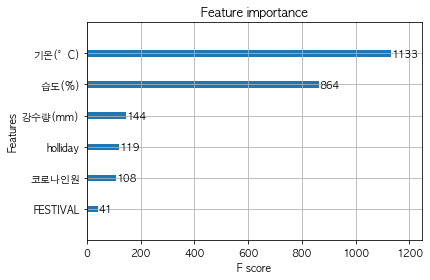

In [ ]:
xgb.plot_importance(model_tree)

In [ ]:
tree_pred = model_tree.predict(mp_testX)
linear_pred = model_linear.predict(mp_testX)

mae_tree = mean_absolute_error(tree_pred, mp_testy)
mae_linear = mean_absolute_error(linear_pred, mp_testy)

In [ ]:
print('tree model precition and real case\n')
print(np.round(tree_pred))
print(np.array(mp_testy).reshape(-1))

print('-'*50)

print('linear model precition and real case\n')
print(np.round(linear_pred))
print(np.array(mp_testy).reshape(-1))

print('-'*50)
print(f'tree boosting MAE : {mae_tree}')
print(f'linear boosting MAE : {mae_linear}')

tree model precition and real case

[58116. 53499. 78149. 95692. 58087.]
[54323. 62398. 81635. 71750. 52864.]
--------------------------------------------------
linear model precition and real case

[62606. 63926. 74943. 73862. 60099.]
[54323. 62398. 81635. 71750. 52864.]
--------------------------------------------------
tree boosting MAE : 9068.67734375
linear boosting MAE : 5170.01640625


In [ ]:
pred_df = pd.DataFrame(columns=['number', 'tree_pred','linear_pred', 'real'])
pred_df['number'] = [1,2,3,4,5]
pred_df['tree_pred'] = tree_pred
pred_df['linear_pred'] = linear_pred
pred_df['real'] = np.array(mp_testy).astype(float).reshape(-1)

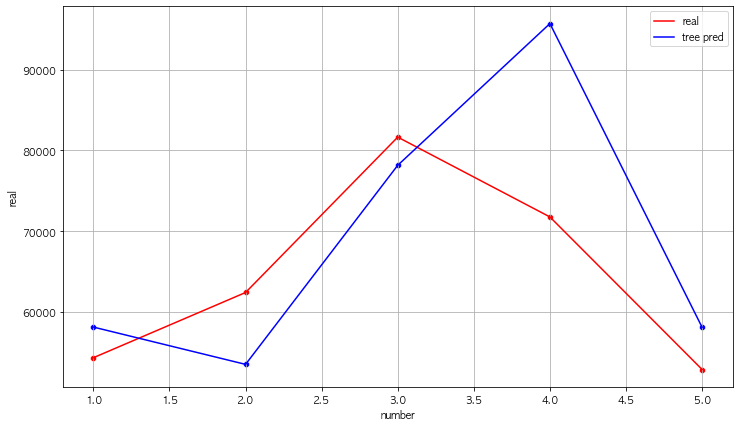

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data=pred_df,x='number', y='real', color='r')
sns.scatterplot(data=pred_df,x='number', y='real', color='r')
sns.lineplot(data=pred_df,x='number', y='tree_pred', color='b')
sns.scatterplot(data=pred_df,x='number', y='tree_pred', color='b')

plt.legend(labels=['real', 'tree pred'])
plt.grid()
plt.show()